# Homework 6

The goal of this homework is to create a tree-based regression model for prediction apartment prices (column 'price').

In this homework we'll again use the New York City Airbnb Open Data dataset - the same one we used in homework 2 and 3.

You can take it from Kaggle or download from here if you don't want to sign up to Kaggle.

Let's load the data:

# Import Libraries


In [50]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Loading the data

In [51]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

df = pd.read_csv('AB_NYC_2019.csv', usecols=columns)
df.reviews_per_month = df.reviews_per_month.fillna(0)

In [52]:
df.columns = df.columns.str.lower()

- Apply the log tranform to price
- Do train/validation/test split with 60%/20%/20% distribution.
- Use the train_test_split function and set the random_state parameter to 1

In [53]:
from sklearn.model_selection import train_test_split
df_full_train,df_test = train_test_split(df,test_size=0.2,random_state=1)
df_train,df_val= train_test_split(df_full_train,test_size=0.25,random_state=1)

In [54]:
#make index not shuffeled 
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [55]:
y_train = np.log1p(df_train.price.values)
y_val = np.log1p(df_val.price.values)
y_test = np.log1p(df_test.price.values)

In [56]:
del df_train['price']
del df_val['price']
del df_test['price']

Now, use DictVectorizer to turn train and validation into matrices:

In [57]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

In [58]:
train_dicts = df_train.fillna(0).to_dict(orient='records')

In [59]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts) #feature matrix

In [60]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

# Question 1

Let's train a decision tree regressor to predict the price variable.

Train a model with max_depth=1

In [61]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

In [62]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=1)

In [63]:
print (export_text(dt, feature_names=dv.get_feature_names()))

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



Which feature is used for splitting the data?

- room_type
- neighbourhood_group
- number_of_reviews
- reviews_per_month

Answer: room_type

# Question 2

Train a random forest model with these parameters:

- n_estimators=10
- random_state=1
- n_jobs=-1 (optional - to make training faster)

In [64]:
from sklearn.ensemble import RandomForestRegressor

In [65]:
rf = RandomForestRegressor(n_estimators=10,
                            random_state=1,
                           n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

What's the RMSE of this model on validation?

- 0.059
- 0.259
- 0.459
- 0.659

In [66]:
y_pred = rf.predict(X_val)
y_pred

array([4.87505509, 4.79647079, 5.38940092, ..., 5.15387428, 4.76825667,
       5.31395147])

In [67]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [68]:
model_rmse = rmse(y_val,y_pred)
print(" RMSE of this model on validation : %s" %(model_rmse))

 RMSE of this model on validation : 0.4615632303514057


Answer: 0.459

# Question 3

Now let's experiment with the n_estimators parameter

- Try different values of this parameter from 10 to 200 with step 10
- Set random_state to 1
- Evaluate the model on the validation dataset

In [69]:
scores=[]
for n in range(10,201,10):
    rf = RandomForestRegressor(n_estimators=n,random_state=1,n_jobs=-1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    model_rmse =  rmse(y_val,y_pred)
    scores.append((n,model_rmse))
    print("Est : %4s , RMSE : %.3f " %(n, model_rmse))


Est :   10 , RMSE : 0.462 
Est :   20 , RMSE : 0.448 
Est :   30 , RMSE : 0.446 
Est :   40 , RMSE : 0.444 
Est :   50 , RMSE : 0.442 
Est :   60 , RMSE : 0.442 
Est :   70 , RMSE : 0.441 
Est :   80 , RMSE : 0.441 
Est :   90 , RMSE : 0.441 
Est :  100 , RMSE : 0.440 
Est :  110 , RMSE : 0.439 
Est :  120 , RMSE : 0.439 
Est :  130 , RMSE : 0.439 
Est :  140 , RMSE : 0.439 
Est :  150 , RMSE : 0.439 
Est :  160 , RMSE : 0.439 
Est :  170 , RMSE : 0.439 
Est :  180 , RMSE : 0.439 
Est :  190 , RMSE : 0.439 
Est :  200 , RMSE : 0.439 


After which value of n_estimators does RMSE stop improving?

- 10
- 50
- 70
- 120

Answer: 120

# Question 4

Let's select the best max_depth:

- Try different values of max_depth: [10, 15, 20, 25]
- For each of these values, try different values of n_estimators from 10 till 200 (with step 10)
- Fix the random seed: random_state=1

In [70]:
rmse_scores2=[]
for d in [10,15,20,25]:
    for n in range(10,201,10):
        rf = RandomForestRegressor(n_estimators=n,max_depth=d,random_state=1,n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        model_rmse =  rmse(y_val,y_pred)
        rmse_scores2.append((n,model_rmse))
        print("Depth:  %s , Est : %4s , RMSE : %.3f " %(d,n, model_rmse))

Depth:  10 , Est :   10 , RMSE : 0.446 
Depth:  10 , Est :   20 , RMSE : 0.442 
Depth:  10 , Est :   30 , RMSE : 0.441 
Depth:  10 , Est :   40 , RMSE : 0.441 
Depth:  10 , Est :   50 , RMSE : 0.441 
Depth:  10 , Est :   60 , RMSE : 0.441 
Depth:  10 , Est :   70 , RMSE : 0.441 
Depth:  10 , Est :   80 , RMSE : 0.441 
Depth:  10 , Est :   90 , RMSE : 0.440 
Depth:  10 , Est :  100 , RMSE : 0.440 
Depth:  10 , Est :  110 , RMSE : 0.440 
Depth:  10 , Est :  120 , RMSE : 0.440 
Depth:  10 , Est :  130 , RMSE : 0.440 
Depth:  10 , Est :  140 , RMSE : 0.440 
Depth:  10 , Est :  150 , RMSE : 0.440 
Depth:  10 , Est :  160 , RMSE : 0.440 
Depth:  10 , Est :  170 , RMSE : 0.440 
Depth:  10 , Est :  180 , RMSE : 0.440 
Depth:  10 , Est :  190 , RMSE : 0.440 
Depth:  10 , Est :  200 , RMSE : 0.440 
Depth:  15 , Est :   10 , RMSE : 0.450 
Depth:  15 , Est :   20 , RMSE : 0.441 
Depth:  15 , Est :   30 , RMSE : 0.440 
Depth:  15 , Est :   40 , RMSE : 0.439 
Depth:  15 , Est :   50 , RMSE : 0.438 


What's the best max_depth:

- 10
- 15
- 20
- 25

Answer: 25

Bonus question (not graded):

- Will the answer be different if we change the seed for the model?

Answer: yes

# Question 5

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorith, it finds the best split. When doint it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the imporatant features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

For this homework question, we'll find the most important feature:

Train the model with these parametes:
- n_estimators=10,
- max_depth=20,
- random_state=1,
- n_jobs=-1 (optional)
- Get the feature importance information from this model

In [71]:
rf1 = RandomForestRegressor(n_estimators=10,max_depth=20,random_state=1,n_jobs=-1)
rf1.fit(X_train, y_train)

y_pred = rf.predict(X_val)
x = rf1.feature_importances_.round(3)
y = dv.get_feature_names()
print(list(zip(x,y)))
print(max(x),y[12])

[(0.076, 'availability_365'), (0.03, 'calculated_host_listings_count'), (0.153, 'latitude'), (0.154, 'longitude'), (0.053, 'minimum_nights'), (0.0, 'neighbourhood_group=Bronx'), (0.001, 'neighbourhood_group=Brooklyn'), (0.034, 'neighbourhood_group=Manhattan'), (0.001, 'neighbourhood_group=Queens'), (0.0, 'neighbourhood_group=Staten Island'), (0.042, 'number_of_reviews'), (0.054, 'reviews_per_month'), (0.392, 'room_type=Entire home/apt'), (0.004, 'room_type=Private room'), (0.005, 'room_type=Shared room')]
0.392 room_type=Entire home/apt


What's the most important feature?

- neighbourhood_group=Manhattan -> 0.034
- room_type=Entire home/apt -> 0.392
- longitude -> 0.154
- latitude -> 0.153 

Answer: room_type=Entire home/apt -> 0.392

# Question 6

Now let's train an XGBoost model! For this question, we'll tune the eta parameter

- Install XGBoost
- Create DMatrix for train and validation
- Create a watchlist
- Train a model with these parameters for 100 rounds:
- xgb_params = {
   - 'eta': 0.3, 
   - 'max_depth': 6,
   -  'min_child_weight': 1,

   -  'objective': 'reg:squarederror',
   -  'nthread': 8,

   -  'seed': 1,
   -  'verbosity': 1,
}

In [72]:
!pip install xgboost

In [73]:
import xgboost as xgb

In [74]:
features = dv.get_feature_names()

dtrain = xgb.DMatrix(X_train,label=y_train,feature_names=features)

dval = xgb.DMatrix(X_val,label=y_val,feature_names=features)

In [75]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [76]:
watchlist = [(dtrain,'train'),(dval,'val')]

In [77]:
scores = {}

In [78]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params,dtrain,num_boost_round=100,evals=watchlist)

In [79]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.3'

Now change eta first to 0.1 and then to 0.01

In [81]:
scores.keys(),scores.items()

(dict_keys(['eta=0.3']),
 dict_items([('eta=0.3',     num_iter  train_rmse  val_rmse
 0          0     3.02752   3.02415
 1          1     2.14667   2.14390
 2          2     1.53878   1.53721
 3          3     1.12557   1.12523
 4          4     0.85100   0.85174
 ..       ...         ...       ...
 95        95     0.36742   0.43579
 96        96     0.36698   0.43584
 97        97     0.36644   0.43595
 98        98     0.36582   0.43597
 99        99     0.36478   0.43621
 
 [100 rows x 3 columns])]))

In [82]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params,dtrain,num_boost_round=100,evals=watchlist)

In [83]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.1'

In [84]:
scores.keys(),scores.items()

(dict_keys(['eta=0.3', 'eta=0.1']),
 dict_items([('eta=0.3',     num_iter  train_rmse  val_rmse
 0          0     3.02752   3.02415
 1          1     2.14667   2.14390
 2          2     1.53878   1.53721
 3          3     1.12557   1.12523
 4          4     0.85100   0.85174
 ..       ...         ...       ...
 95        95     0.36742   0.43579
 96        96     0.36698   0.43584
 97        97     0.36644   0.43595
 98        98     0.36582   0.43597
 99        99     0.36478   0.43621
 
 [100 rows x 3 columns]), ('eta=0.1',     num_iter  train_rmse  val_rmse
 0          0     3.87217   3.86889
 1          1     3.49150   3.48840
 2          2     3.14949   3.14635
 3          3     2.84232   2.83951
 4          4     2.56650   2.56412
 ..       ...         ...       ...
 95        95     0.40406   0.43272
 96        96     0.40397   0.43272
 97        97     0.40361   0.43269
 98        98     0.40321   0.43260
 99        99     0.40277   0.43250
 
 [100 rows x 3 columns])]))

In [86]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params,dtrain,num_boost_round=100,evals=watchlist)

In [87]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.01'

In [88]:
scores.keys(),scores.items()

(dict_keys(['eta=0.3', 'eta=0.1', 'eta=0.01']),
 dict_items([('eta=0.3',     num_iter  train_rmse  val_rmse
 0          0     3.02752   3.02415
 1          1     2.14667   2.14390
 2          2     1.53878   1.53721
 3          3     1.12557   1.12523
 4          4     0.85100   0.85174
 ..       ...         ...       ...
 95        95     0.36742   0.43579
 96        96     0.36698   0.43584
 97        97     0.36644   0.43595
 98        98     0.36582   0.43597
 99        99     0.36478   0.43621
 
 [100 rows x 3 columns]), ('eta=0.1',     num_iter  train_rmse  val_rmse
 0          0     3.87217   3.86889
 1          1     3.49150   3.48840
 2          2     3.14949   3.14635
 3          3     2.84232   2.83951
 4          4     2.56650   2.56412
 ..       ...         ...       ...
 95        95     0.40406   0.43272
 96        96     0.40397   0.43272
 97        97     0.40361   0.43269
 98        98     0.40321   0.43260
 99        99     0.40277   0.43250
 
 [100 rows x 3 columns]

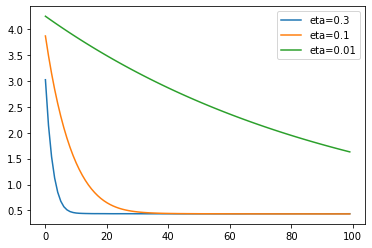

In [89]:
for eta, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_rmse, label=eta)
    

plt.legend()

Which eta leads to the best RMSE score on the validation dataset?

- 0.3
- 0.1
- 0.01

In [ ]:
Answer: 0.01